In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
# from evaluation import smape
from sklearn.metrics import mean_squared_error
import ipdb

%matplotlib inline

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from matplotlib.dates import DateFormatter
import os

# read files from directory
aq_file_list = []
airQ_data_dict = {}

# read the file names into list
# for aq_file in os.listdir(imputed_data_path):
#     if '.csv' in aq_file:
#         aq_file_list.append(aq_file)
#         airQ_df = pd.read_csv(imputed_data_path+aq_file, header=0, index_col=0)
#         airQ_df.time = airQ_df.time.apply(lambda x: pd.Timestamp(x))
#         airQ_data_dict[aq_file.replace("_imputed.csv", '')] = airQ_df
 
aq_kurla = pd.read_csv("kurla_cleaned.csv", header=0, index_col=0)
# aq_kurla = aq_kurla.time.apply(lambda x: pd.Timestamp(x))

aq_kurla

,PM2.5,PM10,NO,NO2,SO2,CO,Ozone,RH,WS,WD,AT,Date
0,137.96,272.00,7.97,129.990000,73.270,1.882128,3.470,44.770000,0.820000,236.970000,25.740000,17-03-2021 00:00
1,111.31,272.00,7.97,94.086667,67.162,1.882128,3.566,50.273333,0.846667,219.323333,25.523333,17-03-2021 01:00
2,49.00,272.00,7.97,58.183333,61.054,1.496000,3.662,55.776667,0.873333,201.676667,25.306667,17-03-2021 02:00
3,32.83,272.00,7.97,22.280000,54.946,1.084000,3.758,61.280000,0.900000,184.030000,25.090000,17-03-2021 03:00
4,50.19,272.00,17.54,42.045000,48.838,0.672000,3.854,60.695000,0.815000,151.750000,24.715000,17-03-2021 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
17559,14.93,217.88,10.18,25.750000,25.550,0.330000,49.060,62.990000,2.590000,231.420000,32.500000,18-03-2023 15:00
17560,17.07,250.22,12.90,24.920000,25.540,0.260000,44.690,66.230000,2.860000,242.130000,31.920000,18-03-2023 16:00
17561,12.36,236.92,10.55,22.700000,25.560,0.230000,48.020,70.650000,2.540000,243.530000,31.170000,18-03-2023 17:00
17562,13.25,189.68,10.98,24.550000,25.550,0.250000,43.670,77.600000,2.050000,244.630000,30.360000,18-03-2023 18:00


Important Functions

In [19]:
# convert series to supervised learning
def series_to_supervised(data_df, n_in=1, dropnan=True):
	data = data_df.values
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, 1):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	agg.index = data_df.index
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna()
        
	return agg

In [20]:
# return the dictionary dataframes according to the air quality type for further training & testing
# drop the NaN in the separated air types table
import ipdb

def airQualTypesDataDict(data_df):
    # dictionary for storing dataframes
    data_dict = {}
    
    # air quality types list
    air_types = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    
    # features columns containing 'time' label
    feature_cols = list(set(data_df.columns) - set(air_types))
    
    for air in air_types:
        # get all the columns
        data_cols = feature_cols.copy()
        data_cols.append(air)
        
        # get the dataframe with the specific air type
        air_data_df = data_df[data_cols]
        
        # choose the 'time' as the index
        air_data_df.time = air_data_df.time.apply(lambda x: pd.Timestamp(x))
        air_data_df = air_data_df.set_index('time')
        data_dict[air] = air_data_df
        
    
    return data_dict
    
    
# drop the NaN in the concated air types table
def getTrainTestDataDropna(data_df):
    # dropna
    print ('Total rows before dropna: {}'.format(len(data_df)))
    data_df = data_df.dropna()
    data_df = data_df.set_index('time')
    print ('Total rows after dropna: {}'.format(len(data_df)))

    # labels columns
    label_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    feature_cols = list(set(data_df.columns) - set(label_cols))
    
    # validation set
    val_df = data_df[-48:]
    X_val = val_df[feature_cols]
    y_val = val_df[label_cols]

    # train set
    train_df = data_df[:-48]
    X_train = train_df[feature_cols]
    y_train = train_df[label_cols]
    
    return X_train, X_val, y_train, y_val

In [21]:
# return training & validation data
def splitTrainValData(data_df, label, n_in, is_predict):
    # pred_size
    pred_size = 48
    
    # reframed dataset
    data_df = data_df.astype(float)
    
    # extract the label column firstly
    features_df = data_df.drop(columns=[label])
    label_col = data_df[[label]]
    
    reframed = series_to_supervised(features_df, n_in)
    # concat the label column
    reframed = reframed.merge(label_col, on='time', how='left')
    
    # drop the NaN the last 48 hours before
    reframed_test = reframed[-pred_size:]
    reframed_train = reframed[:-pred_size]
    reframed_train = reframed_train.dropna()
    
    reframed_all = pd.DataFrame()
    if is_predict:
        # reframed data including the test set for final prediction
        reframed_all = pd.concat([reframed_train, reframed_test], ignore_index=False)
    else:
        # reframed data including the validation dataset
        reframed_all = reframed_train
    
    # split into train and test sets
    # index
    train_index = reframed_all.index[:-pred_size]
    test_index = reframed_all.index[-pred_size:]
    
    values = reframed_all.values
    # scaled features
    features_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = features_scaler.fit_transform(values[:,:-1])
    
    # scaled labels
    labels_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_label = labels_scaler.fit_transform(values[:,-1].reshape(-1,1))
    values = np.column_stack((scaled_features, scaled_label))

    # split the train & test
    train = values[:-pred_size, :]
    test = values[-pred_size:, :]
    
    # split into input and outputs
    # features take all values except the var1
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    return train_X, test_X, train_y, test_y, train_index, test_index, labels_scaler



Evaluation

In [22]:
import numpy as np
import math
# from evaluate import smape
from sklearn.metrics import r2_score


def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))


# from evaluation import smape

def evaluation(real, pred):
    mse_score = mean_squared_error(real, pred)
    rmse_score = math.sqrt(mse_score)
    smape_score = smape(real, pred)
    
    print ("MSE: {}".format(mse_score))
    print ("RMSE: {}".format(rmse_score))
    print ("SMAPE: {}".format(smape_score))
    print('R^2 score: {:2f}'.format(r2_score(real, pred)))
    return rmse_score, smape_score
    
A = np.array([2,3,4,5,6,7,8,9])
F = np.array([1,3,5,4,6,7,10,7])
print(smape(A, F))

0.0


XG-Boost

In [23]:
import ipdb
from xgboost import XGBRegressor

airQ_types = ['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']

def xgb(airQ_df, n_estimators, n_in, is_predict):
    rmse_dict = {}
    smape_dict = {}
    for air_type in airQ_types[:3]:
        # final optimal parameters
        n_in = 1
        n_est = 100
        
        if air_type == 'PM2.5':
            n_in = 12
            n_est = 1000
        elif air_type == 'PM10':
            n_in = 1
            n_est = 200
        elif air_type == 'O3':
            n_in = 15
            n_est = 100
            
#         n_estimators = n_est
            
            
        air_type_dict = airQualTypesDataDict(airQ_df)
        X_train, X_val, y_train, y_val, train_index, val_index, scaler = \
            splitTrainValData(air_type_dict[air_type], air_type, n_in, is_predict)
        
        # Model
        model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=0.05, max_depth=3, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)

        # time count
        start = time.time()

        # make a prediction
        model_xgb.fit(X_train, y_train)
        yhat = model_xgb.predict(X_val)

        # invert scaling for forecast
#         inv_yhat = concatenate((yhat, X_val[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1, 1))
        inv_yhat = inv_yhat[:,0]

        # invert scaling for actual
#         y_val = y_val.reshape((len(y_val), 1))
#         inv_y = concatenate((y_val, X_val[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(y_val.reshape(-1, 1))
        inv_y = inv_y[:,0]

        end = time.time()
        print('This took {} seconds.'.format(end - start))

        # inversed labels dataframe
        y_val_inversed = inv_y
        y_val_inversed_df = pd.DataFrame(y_val_inversed, index=val_index, columns=[air_type])

        pred_inversed = [x if x > 0 else 0 for x in inv_yhat]
        pred_inversed_df = pd.DataFrame(pred_inversed, index=val_index, columns=[air_type])

        # Evaluation result
        rmse_score, smape_score = evaluation(y_val_inversed, pred_inversed)
        rmse_dict[air_type] = rmse_score
        smape_dict[air_type] = smape_score

        # draw line chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(val_index, y_val_inversed_df[[air_type]], color='b', label='True')
        ax.plot(val_index, pred_inversed_df[[air_type]], color='orange', label='Prediction')

        ax.set_title(air_type, fontweight="bold", size=16)
        ax.legend(loc="upper right")
        myFmt = DateFormatter("%m %d %H")
        ax.xaxis.set_major_formatter(myFmt)

        ## Rotate date labels automatically
        fig.autofmt_xdate()
        plt.show()
        
    return rmse_dict, smape_dict

In [27]:
aq_kurla.rename(columns = {'Date':'time'}, inplace = True)
aq_kurla.rename(columns = {'Ozone':'O3'}, inplace = True)
# aq_kurla.set_index("time", inplace = True)
aq_kurla

,PM2.5,PM10,NO,NO2,SO2,CO,O3,RH,WS,WD,AT,time
0,137.96,272.00,7.97,129.990000,73.270,1.882128,3.470,44.770000,0.820000,236.970000,25.740000,17-03-2021 00:00
1,111.31,272.00,7.97,94.086667,67.162,1.882128,3.566,50.273333,0.846667,219.323333,25.523333,17-03-2021 01:00
2,49.00,272.00,7.97,58.183333,61.054,1.496000,3.662,55.776667,0.873333,201.676667,25.306667,17-03-2021 02:00
3,32.83,272.00,7.97,22.280000,54.946,1.084000,3.758,61.280000,0.900000,184.030000,25.090000,17-03-2021 03:00
4,50.19,272.00,17.54,42.045000,48.838,0.672000,3.854,60.695000,0.815000,151.750000,24.715000,17-03-2021 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
17559,14.93,217.88,10.18,25.750000,25.550,0.330000,49.060,62.990000,2.590000,231.420000,32.500000,18-03-2023 15:00
17560,17.07,250.22,12.90,24.920000,25.540,0.260000,44.690,66.230000,2.860000,242.130000,31.920000,18-03-2023 16:00
17561,12.36,236.92,10.55,22.700000,25.560,0.230000,48.020,70.650000,2.540000,243.530000,31.170000,18-03-2023 17:00
17562,13.25,189.68,10.98,24.550000,25.550,0.250000,43.670,77.600000,2.050000,244.630000,30.360000,18-03-2023 18:00


Analysis

Suitable sequence hours for prediction

====================== 1 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:25:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.6366167068481445 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


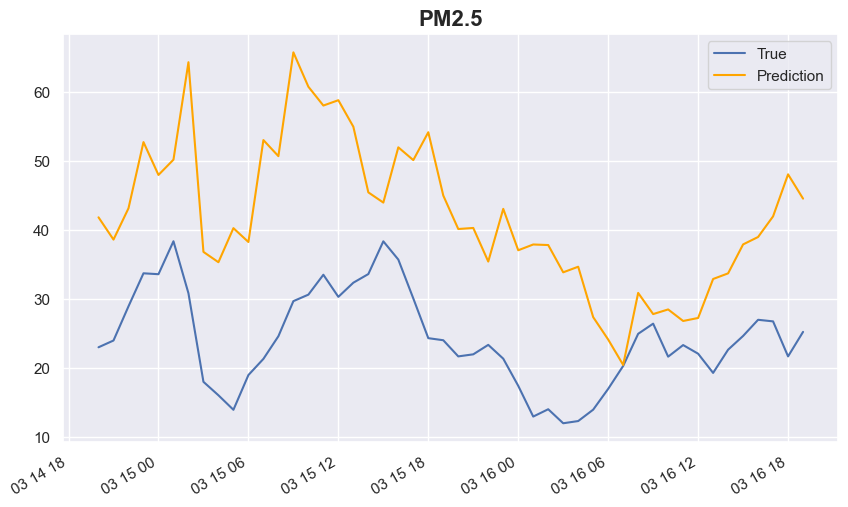

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:25:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.3270137310028076 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


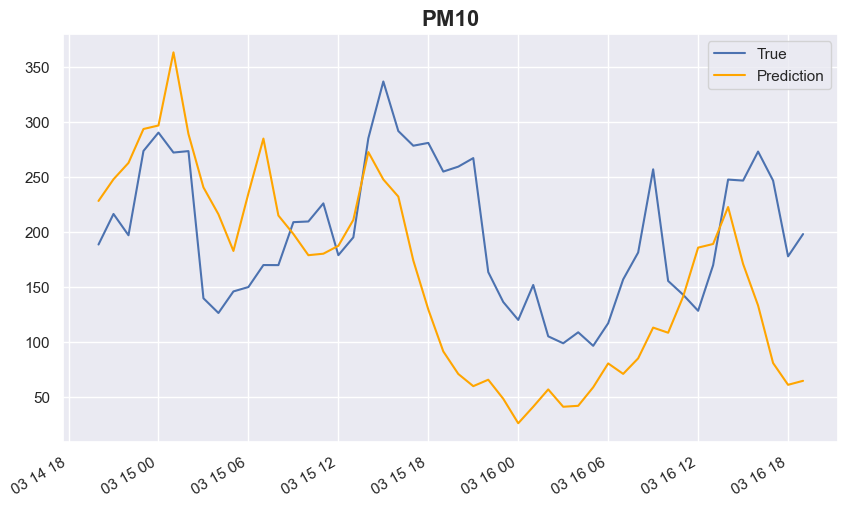

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:25:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.524020671844482 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


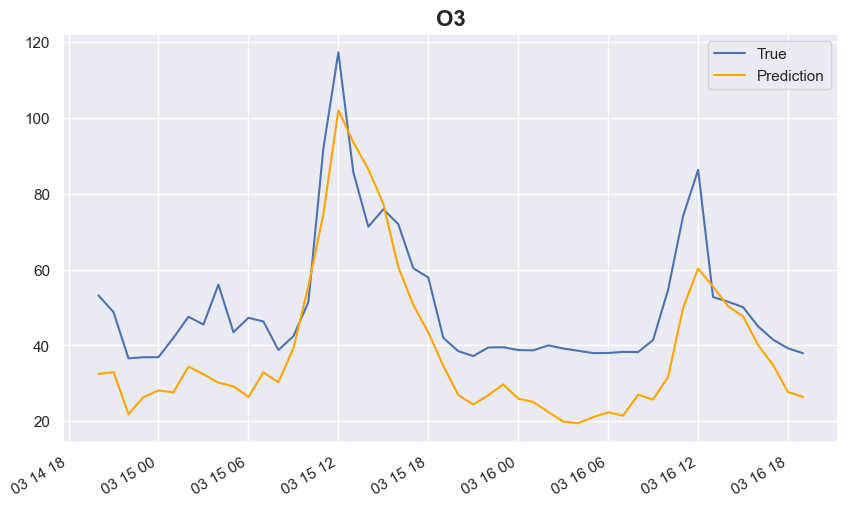

====================== 3 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:25:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.960964679718018 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


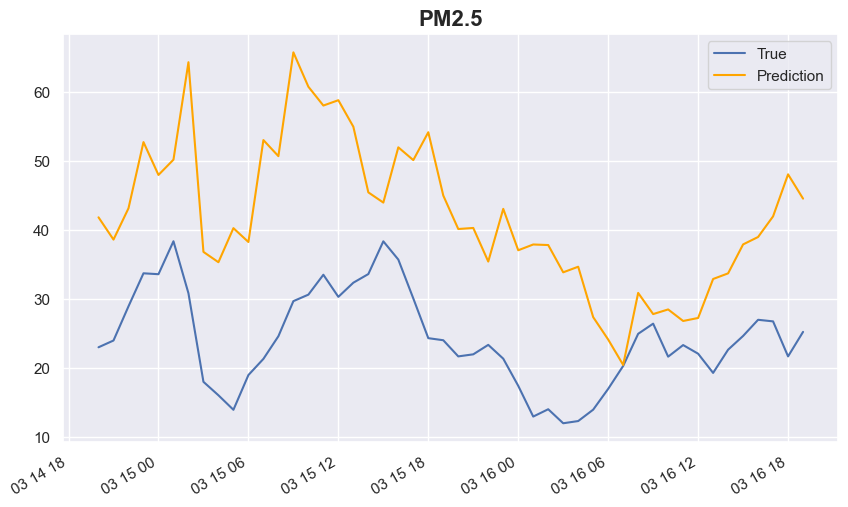

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:26:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.248765468597412 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


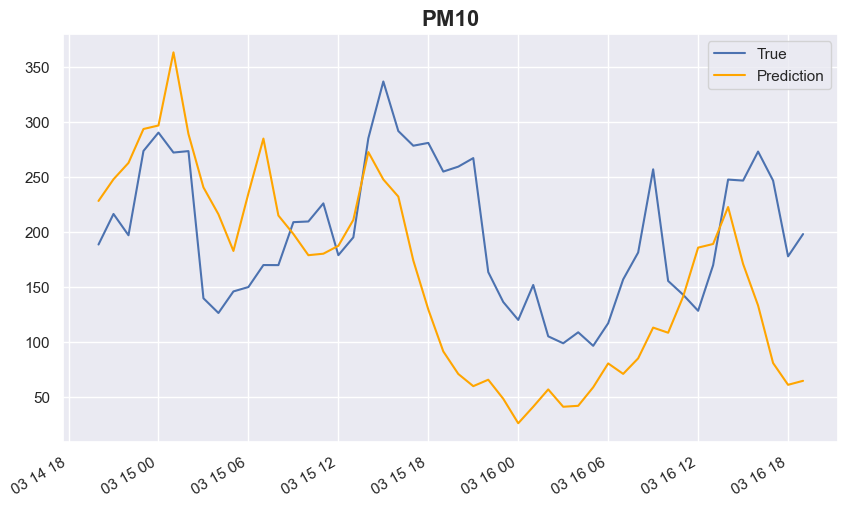

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:26:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.418761253356934 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


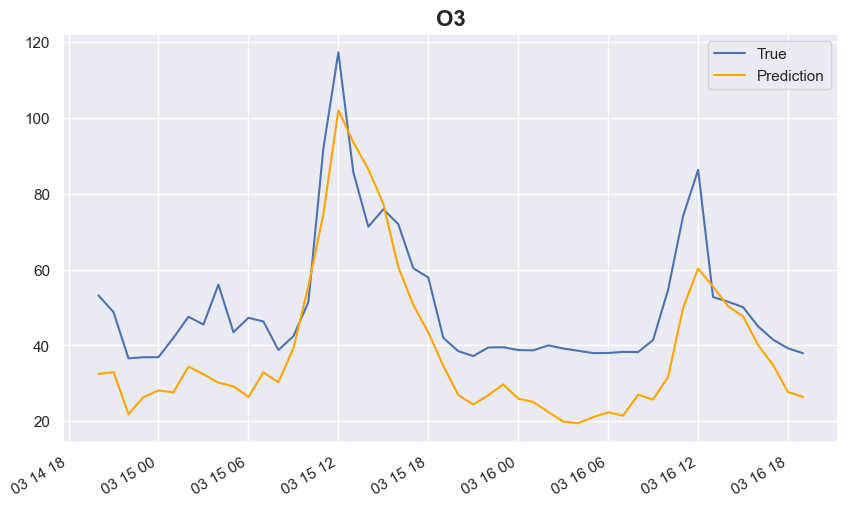

====================== 6 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:26:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.664124011993408 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


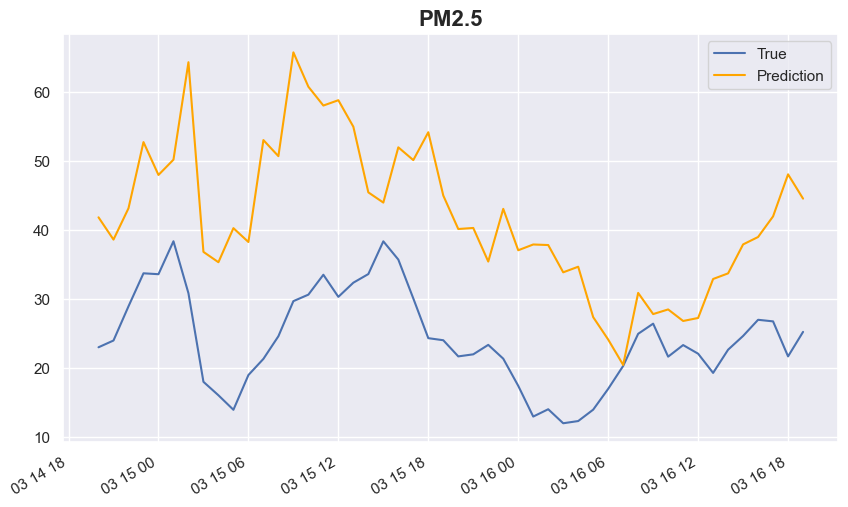

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:26:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.4154820442199707 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


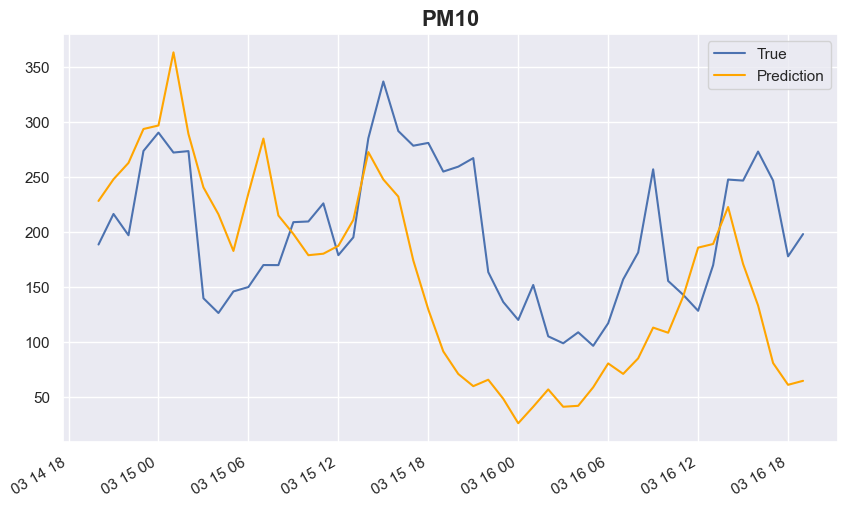

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:27:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.786048889160156 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


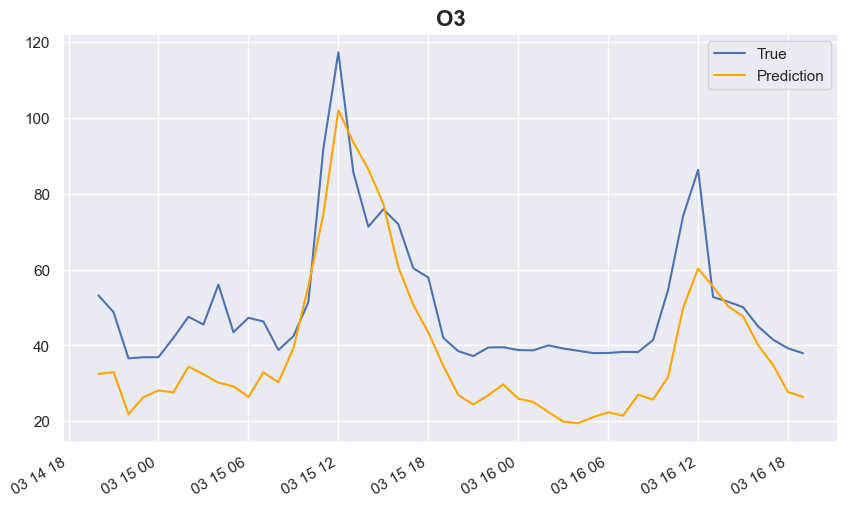

====================== 9 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:27:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.828745126724243 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


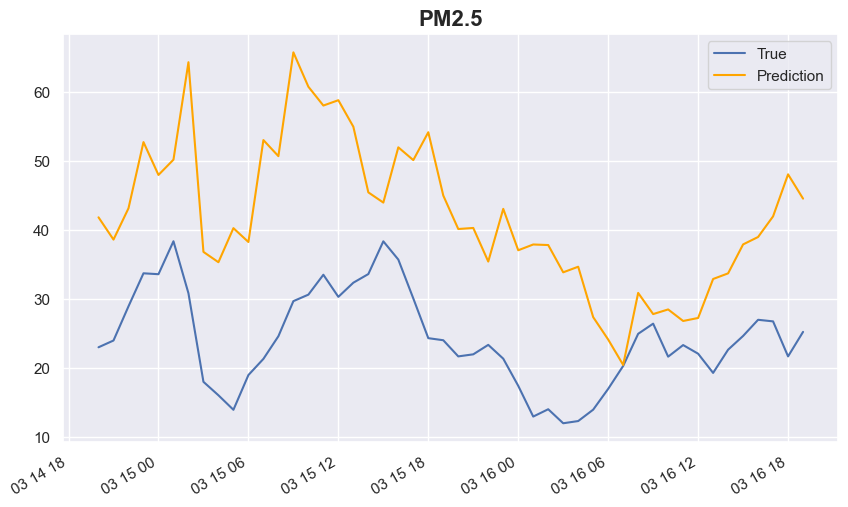

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:27:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.283989906311035 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


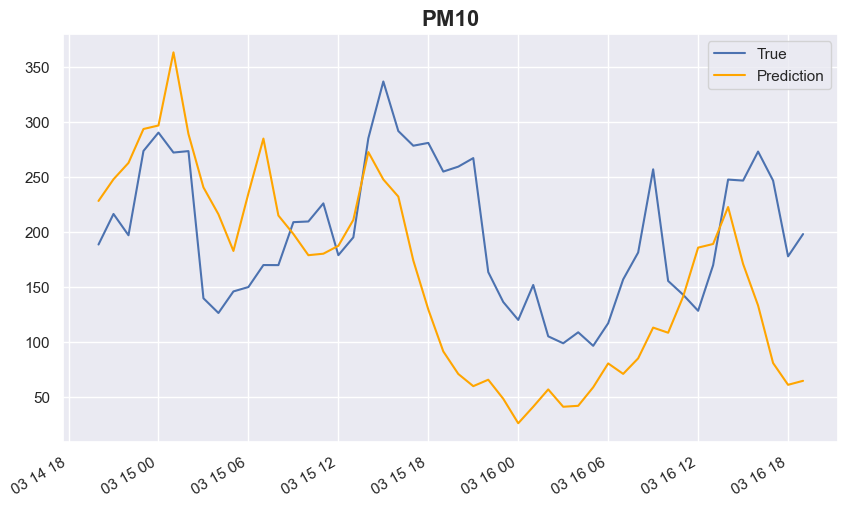

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:27:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.5691142082214355 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


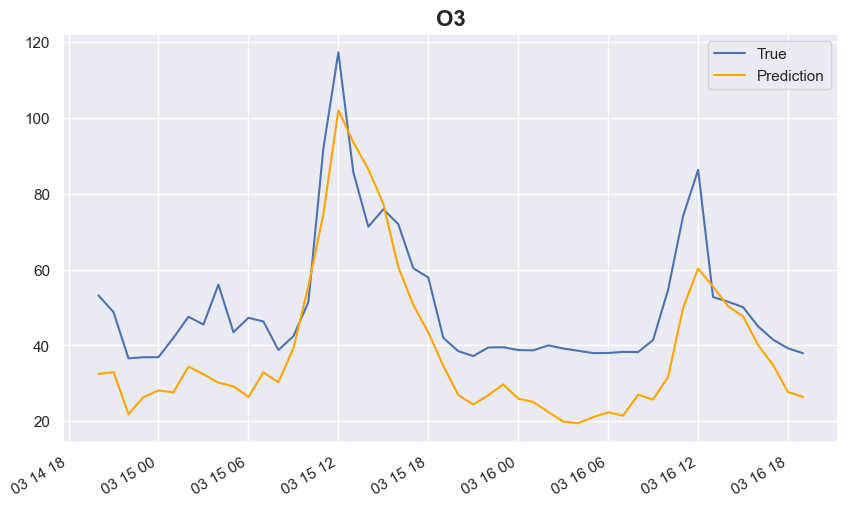

====================== 12 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:28:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.765065670013428 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


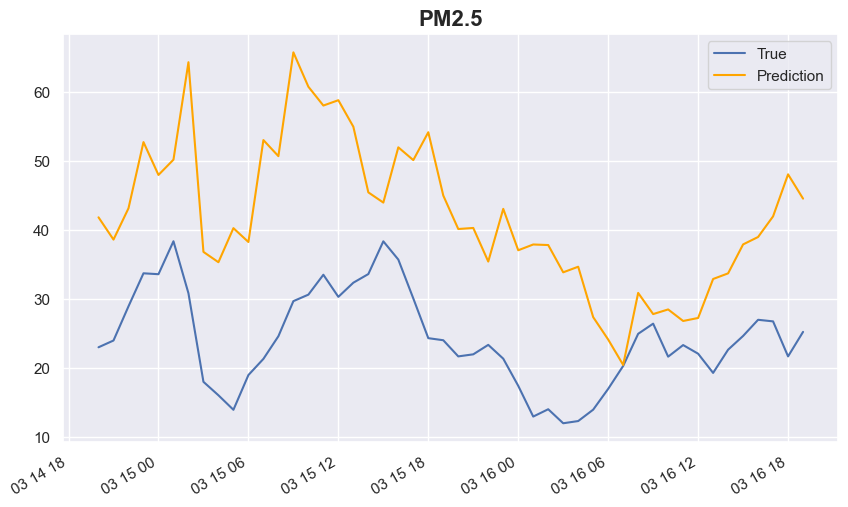

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:28:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.3220386505126953 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


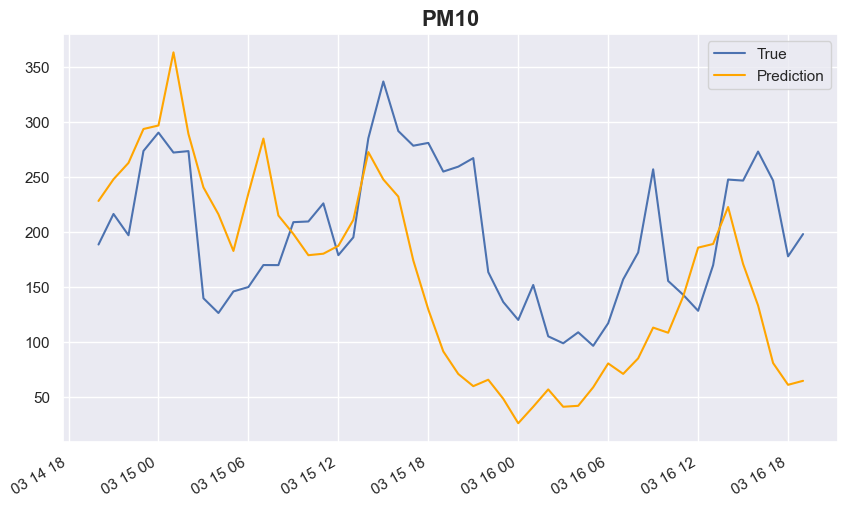

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:28:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 8.351774454116821 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


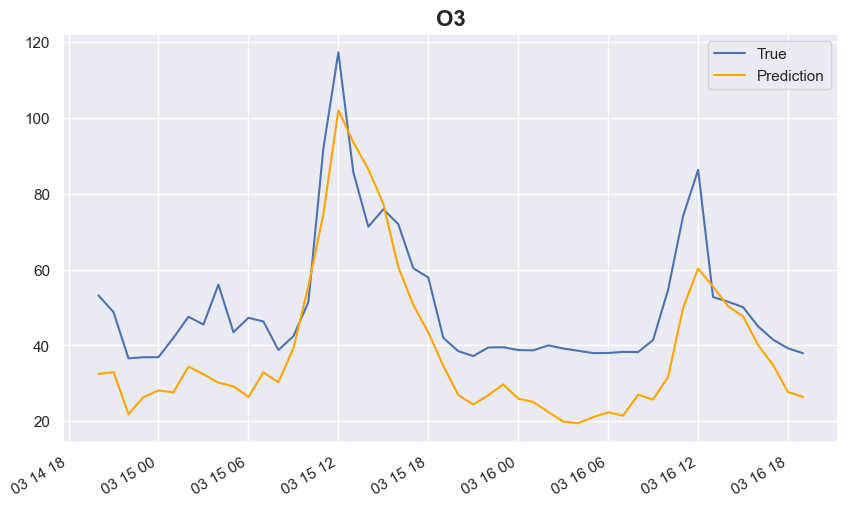

====================== 15 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:28:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.926563739776611 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


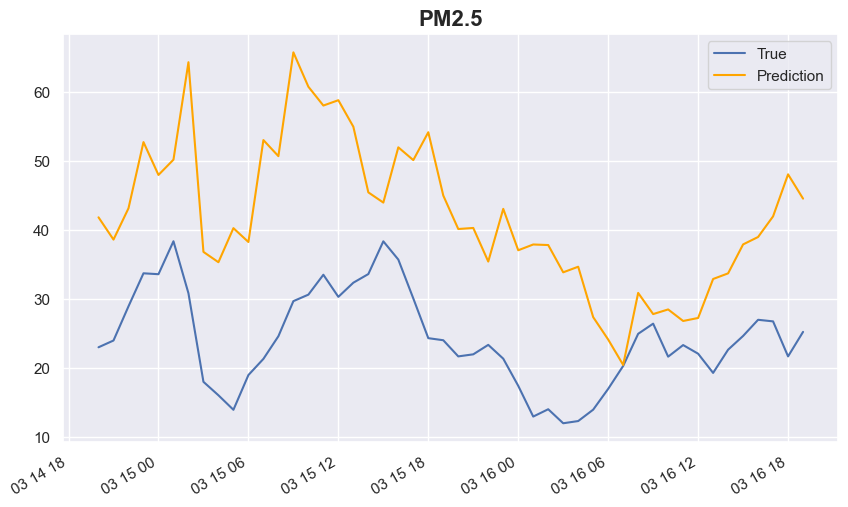

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:29:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.299008369445801 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


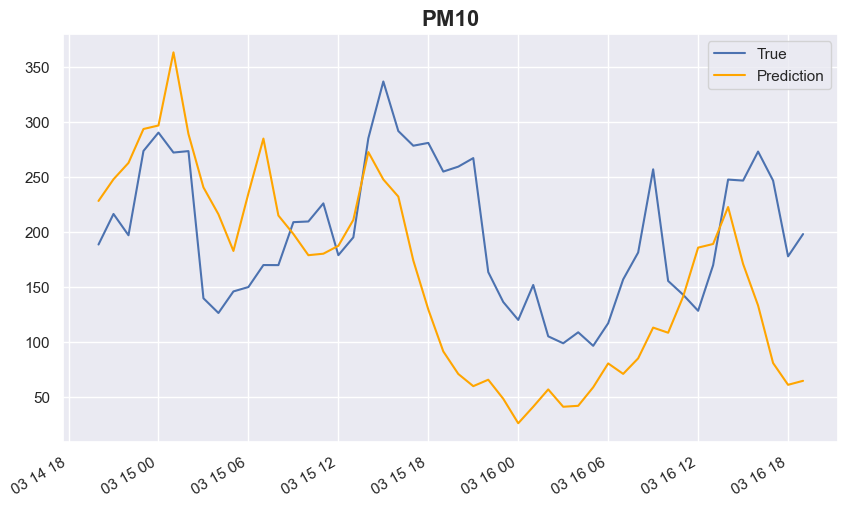

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:29:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 8.35705304145813 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


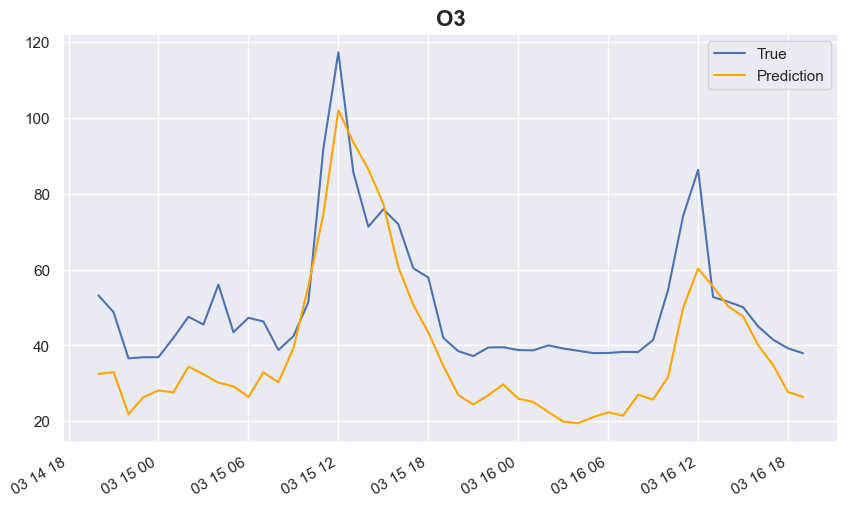

====================== 18 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:29:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.887189626693726 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


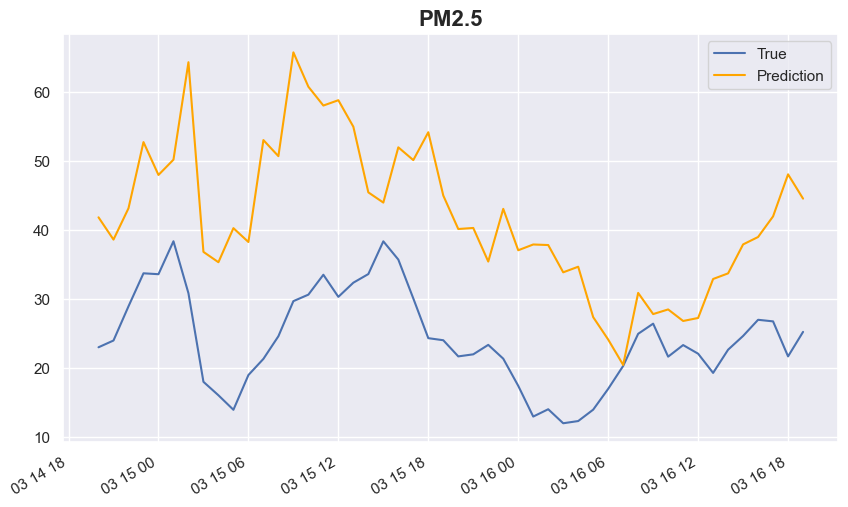

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:29:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.6755106449127197 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


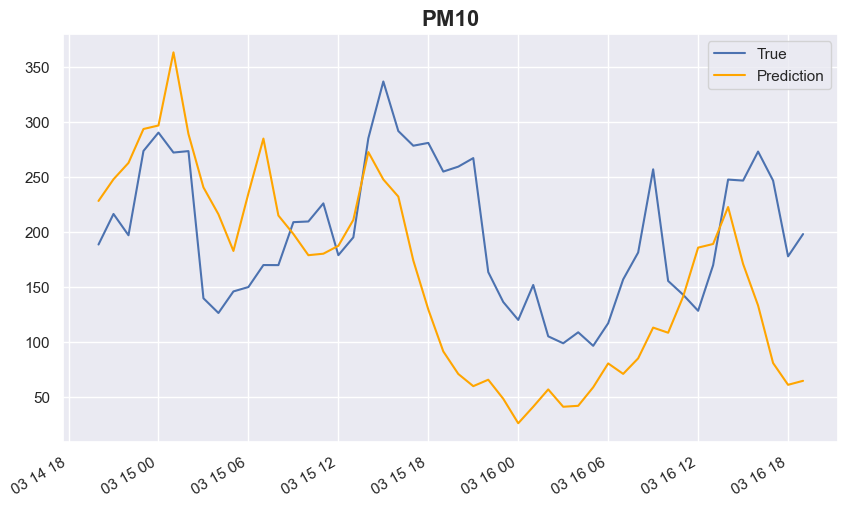

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:30:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 7.733619928359985 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


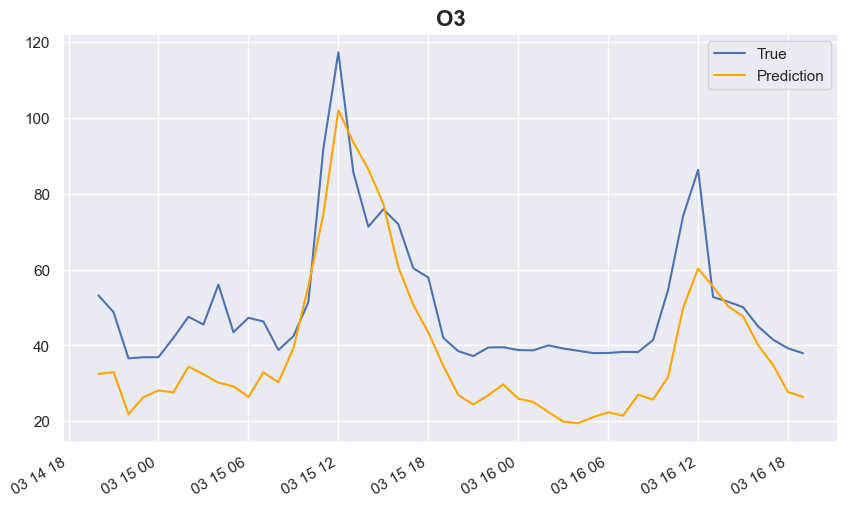

====================== 21 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:30:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.6035237312316895 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


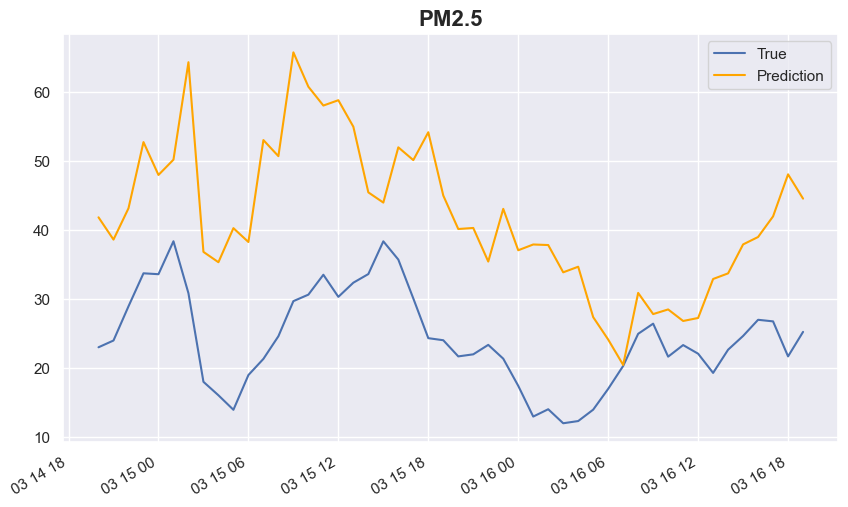

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:30:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.478968381881714 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


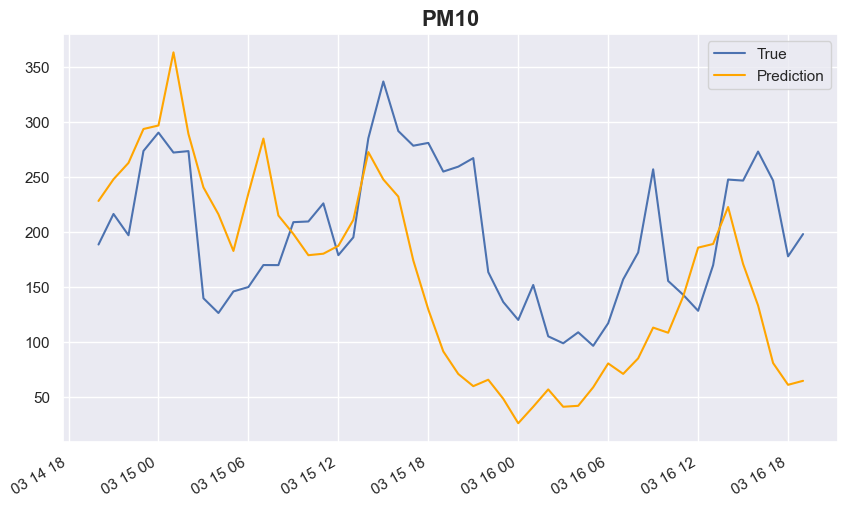

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:30:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 8.314040184020996 seconds.
MSE: 204.84276327566818
RMSE: 14.31232906537815
SMAPE: 0.3294782980378947
R^2 score: 0.315866


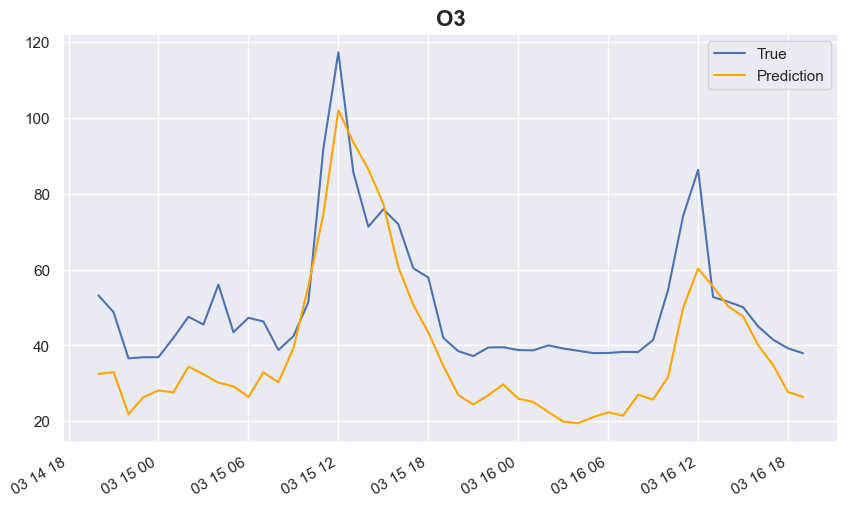

====================== 24 ===========================


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:31:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 6.829566955566406 seconds.
MSE: 384.7617515429094
RMSE: 19.61534479796135
SMAPE: 0.5362512435341135
R^2 score: -7.275616


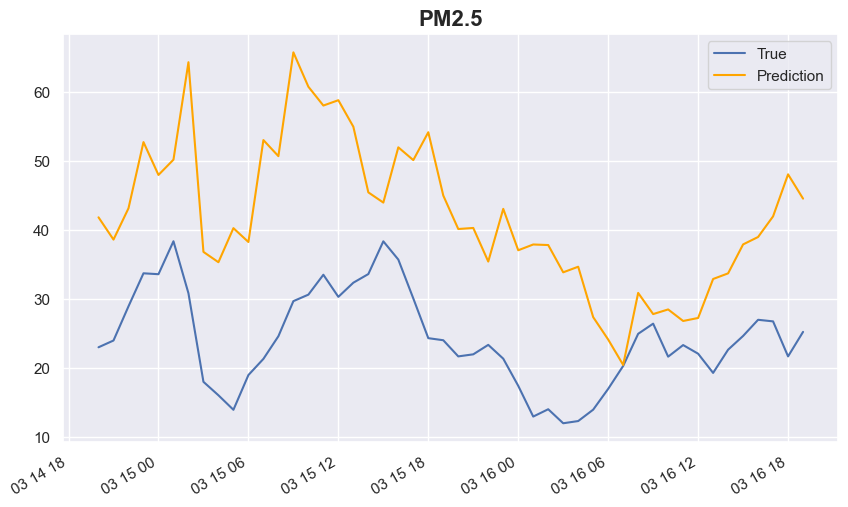

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[02:31:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

This took 3.2899749279022217 seconds.
MSE: 8144.165820129229
RMSE: 90.24503210775222
SMAPE: 0.4963998868840193
R^2 score: -1.073503


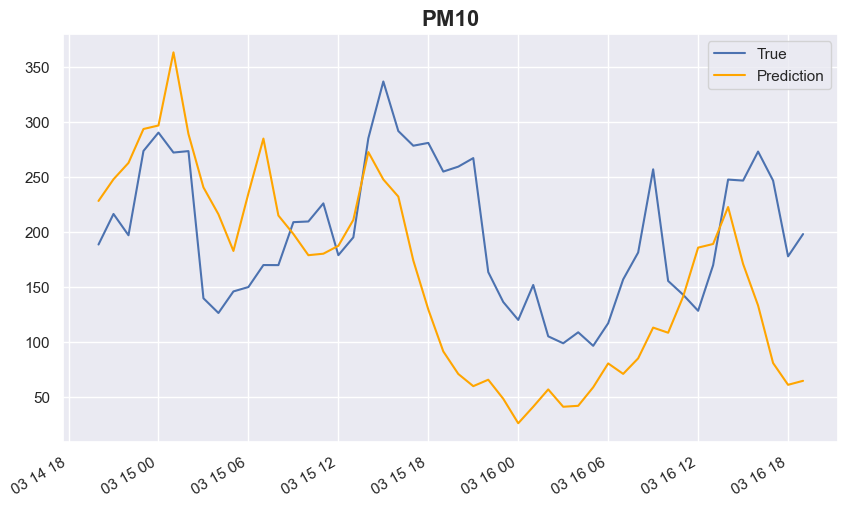

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


KeyboardInterrupt: 

In [28]:
# make a comparison of the different sequence hours for prediction

o_3 = {'rmse': [], 'smape': []}
pm25 = {'rmse': [], 'smape': []}
pm10 = {'rmse': [], 'smape': []}
seq_hours = [1, 3, 6, 9, 12, 15, 18, 21, 24]

for i in seq_hours:
    print ("====================== {} ===========================".format(i))
    rmse_dict, smape_dict = xgb(aq_kurla, 1000, i, False)
    
    # O3
    o_3['rmse'].append(rmse_dict['O3'])
    o_3['smape'].append(smape_dict['O3'])
    
    # PM2.5
    pm25['rmse'].append(rmse_dict['PM2.5'])
    pm25['smape'].append(smape_dict['PM2.5'])
    
    # PM10
    pm10['rmse'].append(rmse_dict['PM10'])
    pm10['smape'].append(smape_dict['PM10'])